In [2]:
import pandas as pd
from datetime import datetime
from typing import Optional

## Data Processing and Cleaning

In [2]:
df = pd.read_csv('../data/my_activity_data=20241206180702.csv')
print('Dataframe Shape:', df.shape)
df.head()

Dataframe Shape: (339, 60)


,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,id,...,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_cadence,average_temp,max_watts,weighted_average_watts
0,2,volume velo,19283.1,5234,5496,226.0,Ride,Ride,NaN,12974413480,...,24.0,64383208,1,a12974413480,iaciHmceNp@lAfArC`BxCXv@rAzB\~@rClFz@tB`AvApAl...,2,NaN,NaN,NaN,NaN
1,2,Entraînement aux poids de nuit,0.0,3743,3743,0.0,WeightTraining,WeightTraining,NaN,12939605259,...,7.0,64383208,1,a12939605259,NaN,2,NaN,NaN,NaN,NaN
2,2,Entraînement aux poids de nuit,0.0,1811,1811,0.0,WeightTraining,WeightTraining,NaN,12932144110,...,4.0,64383208,1,a12932144110,NaN,2,NaN,NaN,NaN,NaN
3,2,Volume,9440.7,3779,3782,57.0,Run,Run,NaN,12924227433,...,95.0,64383208,1,a12924227433,}~biHmseN`Cg@bA]LA`@Lr@B`@Fd@B^FT?~ANx@CdB@h@K...,2,88.7,20.0,477.0,311.0
4,2,Volume,10723.9,4222,4278,87.0,Run,Run,NaN,12907973319,...,114.0,64383208,1,a12907973319,}~biHoseNt@Kr@Wf@CPMn@UTFv@Fv@L`@Bl@L`A@r@Hp@C...,2,88.0,23.0,522.0,316.0


## Calculating Fitness & Freshness

In [21]:
import math

def calculate_fitness_fatigue(training_loads, 
                              lambda_fitness=math.exp(-1/42), 
                              lambda_fatigue=math.exp(-1/7), 
                              initial_fitness=0.0, 
                              initial_fatigue=0.0):
    """
    Calculate daily Fitness and Fatigue values from a sequence of Training Loads.
    
    Parameters:
        training_loads (list or array-like): Daily training load values.
        lambda_fitness (float): Decay factor for Fitness.
        lambda_fatigue (float): Decay factor for Fatigue.
        initial_fitness (float): Starting Fitness value.
        initial_fatigue (float): Starting Fatigue value.
    
    Returns:
        fitness_values (list): Daily Fitness values.
        fatigue_values (list): Daily Fatigue values.
    """
    fitness_values = []
    fatigue_values = []
    
    F_fitness = initial_fitness
    F_fatigue = initial_fatigue
    
    for load in training_loads:
        # Update Fitness
        F_fitness = lambda_fitness * F_fitness + (1 - lambda_fitness) * load
        fitness_values.append(round(F_fitness))
        
        # Update Fatigue
        F_fatigue = lambda_fatigue * F_fatigue + (1 - lambda_fatigue) * load
        fatigue_values.append(round(F_fatigue))
    
    return fitness_values, fatigue_values


# Example usage:
training_loads_example = [7, 122, 10, 0, 148, 0, 123]  # Example: a week of loads
fitness_vals, fatigue_vals = calculate_fitness_fatigue(training_loads_example, initial_fitness=67, initial_fatigue=53)

print("Daily Fitness:", fitness_vals)
print("Daily Fatigue:", fatigue_vals)


Daily Fitness: [66, 67, 66, 64, 66, 64, 66]
Daily Fatigue: [47, 57, 51, 44, 58, 50, 60]


## Formula looks good, but it uses Training Impulse and not Training Load/Relative Effort (Training Impulse is found here : https://www.strava.com/athlete/fitness )

## From what I get, Training Impulse is Training Load/Suffer Score * 1.3, which pretty much matches what I see ? 

## Try and understand the "form" metric after ? 
Sources : 
https://www.reddit.com/r/Strava/comments/6f22g7/can_anyone_simply_explain_the_training_impulse/
https://fellrnr.com/wiki/TRIMP
https://medium.com/strava-engineering/fitness-freshness-updates-5d1057d67fac
https://www.trainingimpulse.com/banisters-trimp-0

## Concatenating the garmin data

In [3]:
# Concatenate multiple CSV files
file_paths = [
    '../data/Garmin_data/RunRacePredictions_20240418_20240727_121718316.csv',
    '../data/Garmin_data/RunRacePredictions_20240727_20241104_121718316.csv',
    '../data/Garmin_data/RunRacePredictions_20241104_20250212_121718316.csv'
]
df_list = [pd.read_csv(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

print('Dataframe Shape:', df.shape)
df.head()

# Output the concatenated DataFrame to a CSV file
output_file_path = '../data/Garmin_data/Garmin_RunRacePredictions_20240418_20250212.csv'
df.to_csv(output_file_path, index=False)  # Save without the index

Dataframe Shape: (352, 12)


In [4]:
df.head()

,userProfilePK,calendarDate,deviceId,timestamp,raceTime5K,raceTime10K,raceTimeHalf,raceTimeMarathon,id,name,amount,Remark
0,121718316.0,2024-04-24,3.431775e+09,2024-04-23T22:04:54.0,1523.0,3279.0,7480.0,16787.0,NaN,NaN,NaN,NaN
1,121718316.0,2024-04-24,3.431775e+09,2024-04-24T07:31:18.0,1523.0,3279.0,7480.0,16787.0,NaN,NaN,NaN,NaN
2,121718316.0,2024-04-25,3.431775e+09,2024-04-25T07:48:00.0,1522.0,3275.0,7468.0,16757.0,NaN,NaN,NaN,NaN
3,121718316.0,2024-04-25,3.431775e+09,2024-04-25T11:53:21.0,1530.0,3299.0,7524.0,16867.0,NaN,NaN,NaN,NaN
4,121718316.0,2024-04-25,3.431775e+09,2024-04-24T22:04:54.0,1522.0,3275.0,7468.0,16757.0,NaN,NaN,NaN,NaN


## Analysing Garmin Data

In [13]:
df = df[['calendarDate', 'timestamp', 'raceTime5K', 'raceTime10K', 'raceTimeHalf', 'raceTimeMarathon']]
df[['raceTime5K', 'raceTime10K', 'raceTimeHalf', 'raceTimeMarathon']] /= 60
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   calendarDate      348 non-null    object 
 1   timestamp         348 non-null    object 
 2   raceTime5K        348 non-null    float64
 3   raceTime10K       348 non-null    float64
 4   raceTimeHalf      348 non-null    float64
 5   raceTimeMarathon  348 non-null    float64
dtypes: float64(4), object(2)
memory usage: 16.6+ KB


In [14]:
summary_stats = df.describe()
print(summary_stats)

       raceTime5K  raceTime10K  raceTimeHalf  raceTimeMarathon
count  348.000000   348.000000    348.000000        348.000000
mean    26.092481    55.585249    127.657711        289.429837
std      0.699636     1.745256      4.700083         12.142531
min     25.266667    53.250000    120.633333        270.700000
25%     25.479167    54.262500    124.654167        279.783333
50%     25.783333    54.950000    126.566667        287.800000
75%     26.737500    57.320833    132.383333        302.483333
max     27.650000    59.316667    136.783333        309.666667


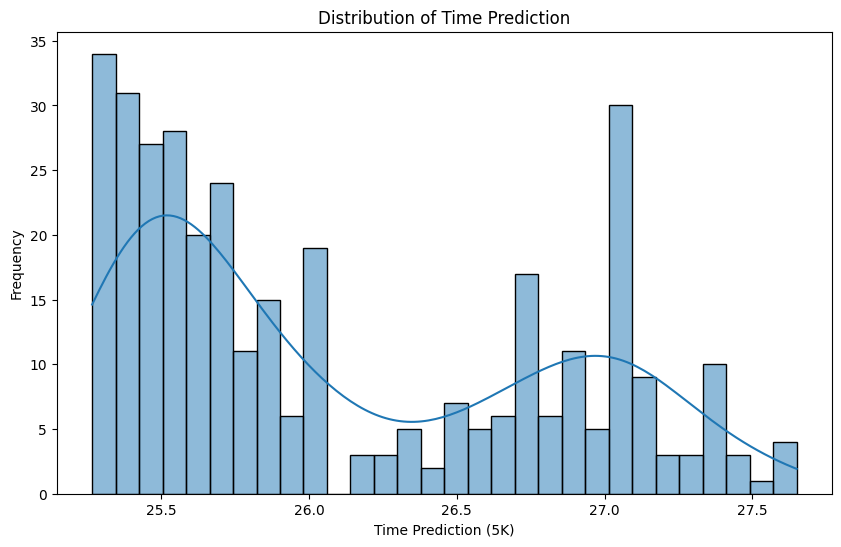

In [15]:
## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['raceTime5K'], bins=30, kde=True)
plt.title('Distribution of Time Prediction')
plt.xlabel('Time Prediction (5K)')
plt.ylabel('Frequency')
plt.show()
